# Inverted Pendulum

In [2]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper functions

This function returns the matrices A, B, Q, and R. Let
g = 9.8 m/s
2
.

In [23]:
def linearized_init(M, m, l, q1, q2, q3, q4, r):
      '''
      Parameters:
      ----------
      M, m: floats
            masses of the rickshaw and the present
      l   : float
            length of the rod
      q1, q2, q3, q4, r : floats
            relative weights of the position and velocity of the rickshaw, the
            angular displacement theta and the change in theta, and the control

      Return
      -------
      A : ndarray of shape (4,4)
      B : ndarray of shape (4,1)
      Q : ndarray of shape (4,4)
      R : ndarray of shape (1,1)
      '''
      g = 9.8
      A = np.array([[0, 1, 0, 0],
                    [0, 0, -m*g/M, 0],
                    [0, 0, 0, 1],
                    [0, 0, g*(M+m)/M/l, 0]])
      B = np.array([[0],
                    [1/M],
                    [0],
                    [1/M/l]])
      Q = np.diag([q1, q2, q3, q4])
      R = np.array([[r]])

      return A, B, Q, R

This function finds the matrix $P$ using `scipy.optimize.root`.

In [41]:
def find_P(A,B,Q,R):
    '''
    Parameters:
    ----------
    A, Q : ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)
    
    Returns
    -------
    P : the matrix solution of the Riccati equation
    '''
    def f(P):
        P = P.reshape((4,4))
        R1 = np.linalg.inv(R)
        W = P@A + A.T@P + Q - P@B@R1@B.T@P
        return W.reshape((16,))
    
    P0 = np.ones(16)
    sol = root(f, P0).x
    return sol.reshape((4,4))

In [42]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.

A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)
P = find_P(A, B, Q, R)

# find eigenvalues
R1 = np.linalg.inv(R)
eigvals, eigvecs = np.linalg.eig(A - B@R1@B.T@P)
print('Eigenvalues of A - B@R1@B.T@P:', eigvals)
print("Any eigenvalues are positive:", np.any(eigvals > 0))

Eigenvalues of A - B@R1@B.T@P: [-1.72873915+0.j         -0.09033907+0.08968387j -0.09033907-0.08968387j
  1.72529514+0.j        ]
Any eigenvalues are positive: True


Z doesn't necessarily converge to zero

This function implements the LQR solution using `scipy.integrate.solve_ivp` to solve the IVP.

In [54]:
def rickshaw(tv, X0, A, B, Q, R, P, n=100):
    '''
    Parameters:
    ----------
    tv : tuple containing start and stop times (t0,tf) that can be passed into solve_ivp
    X0 : Initial conditions on state variables
    A, Q: ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)
    P : ndarray of shape (4,4)
    Returns
    -------
    Z : ndarray of shape (n+1,4), the state vector at each time
    U : ndarray of shape (n+1,), the control values
    '''
    # initialize ode
    def f(t, z):
        return (A - B@R1@B.T@P)@z
    
    # initialize control variables
    R1 = np.linalg.inv(R)
    t0 = tv[0]
    tf = tv[1]

    # solve ode to compute Z, U
    sol = solve_ivp(f, (t0, tf), X0, t_eval=np.linspace(t0, tf, n))
    Z = sol.y
    U = -R1@B.T@P@Z

    return Z, U.flatten()

# Balancing an Inverted Pendulum

We first find the matrix $P$ using the `scipy.optimize.root` method and plot with `tf=6` as well as the `solve_continuous_are`
method and plot with `tf=60`. We then plot the solutions $\tilde{z}$ and $\tilde{u}$. 

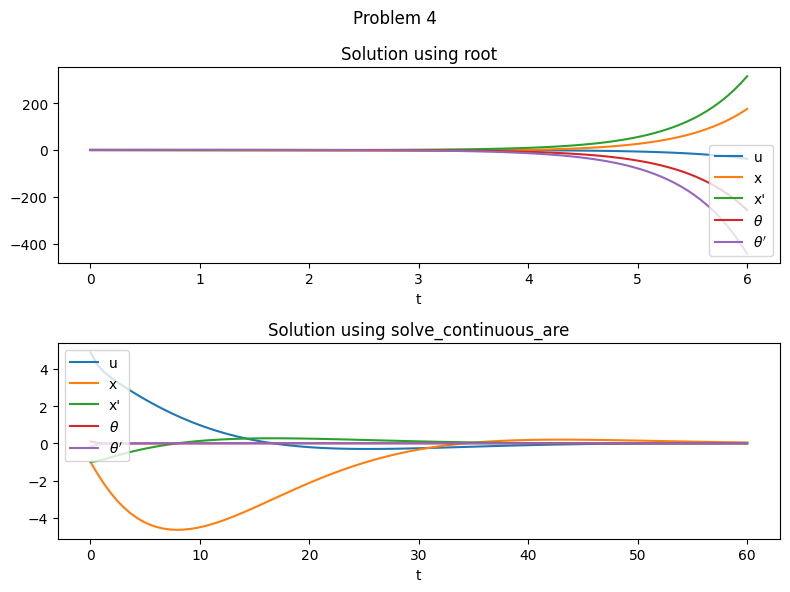

In [7]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.
tf1 = 6
X0 = np.array([-1, -1, .1, -.2])

# first method
A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)
P1 = find_P(A, B, Q, R)
Z1, U1 = rickshaw((0, tf1), X0, A, B, Q, R, P1)

# second method
tf2 = 60
A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)
P2 = solve_continuous_are(A, B, Q, R)
Z2, U2 = rickshaw((0, tf2), X0, A, B, Q, R, P2)

# plot
plt.figure(figsize=(8, 6))
domain1 = np.linspace(0, tf1, len(Z1[0]))
domain2 = np.linspace(0, tf2, len(Z2[0]))
plt.subplot(2, 1, 1)
plt.plot(domain1, U1, label='u')
plt.plot(domain1, Z1[0], label='x')
plt.plot(domain1, Z1[1], label="x'")
plt.plot(domain1, Z1[2], label=r'$\theta$')
plt.plot(domain1, Z1[3], label=r"$\theta'$")
plt.legend()
plt.title("Solution using root")
plt.xlabel("t")

plt.subplot(2, 1, 2)
plt.plot(domain2, U2, label='u')
plt.plot(domain2, Z2[0], label='x')
plt.plot(domain2, Z2[1], label="x'")
plt.plot(domain2, Z2[2], label=r'$\theta$')
plt.plot(domain2, Z2[3], label=r"$\theta'$")
plt.legend()
plt.title("Solution using solve_continuous_are")
plt.xlabel("t")

plt.suptitle("Problem 4")
plt.tight_layout()
plt.show()

# Better Solution
We use the control $\tilde{u}$ from before to solve the nonlinear equation

$\ddot x = \frac{u+m\sin\theta(-l\dot \theta^2+g\cos\theta)}{l(M+m(1-\cos^2\theta))}$,


$\ddot{\theta} = \frac{g(m+M)\sin\theta+\cos\theta(u-lm\dot\theta^2\sin\theta)}{M+m(1-\cos^2\theta)}$.

In [43]:
def nonlinear_ode(t,y,u):
    '''
    y[0] -- x
    y[1] -- x prime
    y[2] -- theta
    y[3] -- theta prime
    '''
    g = 9.8
    return np.array([
        y[1],
        (u(t)+m*np.sin(y[2])*(g*np.cos(y[2])-l*y[3]**2)) / (m+M-m*np.cos(y[2])**2),
        y[3],
        (g*(m+M)*np.sin(y[2])+np.cos(y[2])*(u(t)-l*m*y[3]**2*np.sin(y[2]))) / (l*(m+M-m*np.cos(y[2])**2))
    ])

In [74]:
def iter_solve():
    # initialize solving parameters
    space = np.geomspace(1, 61, 120) - 1
    x, dx, theta, dtheta, uv, tv = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

    M, m = 23., 5.
    l = 4.
    q1, q2, q3, q4 = 1., 1., 1., 1.
    r = 10.
    X0 = np.array([-1, -1, .1, -.2])
    A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)
    P1 = solve_continuous_are(A, B, Q, R)


    for i in range(len(space) - 1):
        t = np.linspace(space[i], space[i+1], 3)
        tv = np.append(tv, t)

        # solve for u and z
        _, u = rickshaw((space[i], space[i+1]), X0, A, B, Q, R, P1, n=3)
        u1 = CubicSpline(t, u)
        z = solve_ivp(nonlinear_ode, (space[i], space[i+1]), X0, t_eval=t, args=(u1,)).y

        # update
        x = np.append(x, z[0])
        dx = np.append(dx, z[1])
        theta = np.append(theta, z[2])
        dtheta = np.append(dtheta, z[3])
        uv = np.append(uv, u)

        X0 = z[:,-1]
    
    return x, dx, theta, dtheta, uv, tv

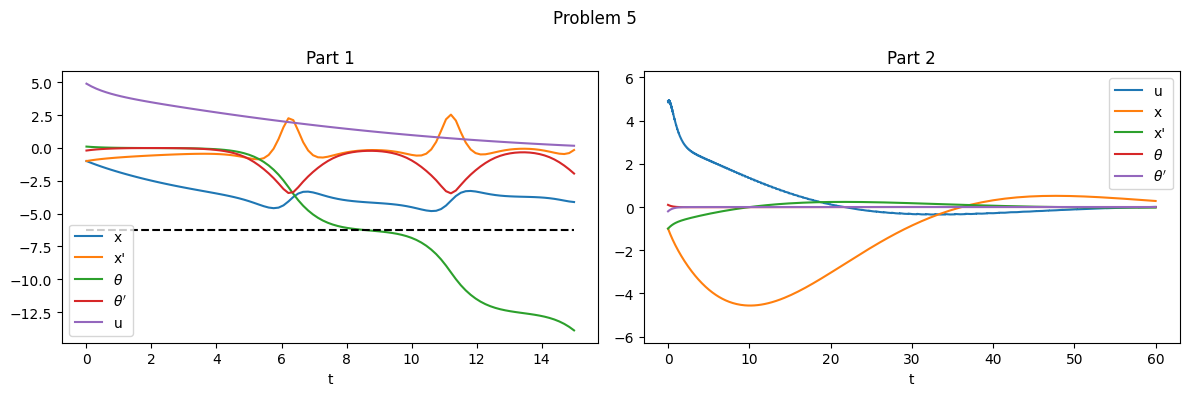

In [77]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.
tf = 15
X0 = np.array([-1, -1, .1, -.2])
G = 9.8

# initialize
A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)
P2 = solve_continuous_are(A, B, Q, R)
t = np.linspace(0, tf, 100)
Z, U = rickshaw((0, tf), X0, A, B, Q, R, P2)
u = CubicSpline(t, U)

# solve ode
sol = solve_ivp(nonlinear_ode, (0, tf), X0, t_eval=t, args=(u,))
x, dx, theta, dtheta, uv, tv = iter_solve()

# plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(sol.t, sol.y[0], label='x')
plt.plot(sol.t, sol.y[1], label="x'")
plt.plot(sol.t, sol.y[2], label=r'$\theta$')
plt.plot(sol.t, sol.y[3], label=r"$\theta'$")
plt.plot(sol.t, u(sol.t), label='u')
plt.plot(sol.t, -2*np.pi*np.ones(len(sol.t)), 'k--')
plt.xlabel('t')
plt.title('Part 1')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tv, uv, label='u')
plt.plot(tv, x, label='x')
plt.plot(tv, dx, label="x'")
plt.plot(tv, theta, label=r'$\theta$')
plt.plot(tv, dtheta, label=r"$\theta'$")
plt.xlabel('t')
plt.title('Part 2')
plt.ylim(-2*np.pi, 2*np.pi)
plt.legend()

plt.suptitle("Problem 5")
plt.tight_layout()
plt.show()